In [1]:
import pandas as pd
import numpy as np

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# for handling SettingWithCopyWarning
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data = pd.read_csv("./data.csv", low_memory=False).drop_duplicates()
data["input"] = data["input"].astype(float)
data["initial_value"] = data["initial_value"].astype(float)
data["cbrt_ideal"] = data["cbrt_ideal"].astype(float)
data["cbrt_safe_implementation"] = data["cbrt_safe_implementation"].astype(float)
data["cbrt_implementation"] = -1

for col in data.columns:
    if col.startswith("cbrt_iter"):
        data[col] = data[col].astype(float)
data

,input,initial_value,cbrt_ideal,cbrt_safe_implementation,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,...,cbrt_iter_91,cbrt_iter_92,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99,cbrt_implementation
0,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3,3.368168e+18,1.447428e+19,1.498987e+18,1.498987e+18,9.654879e+18,6.448630e+18,4.326085e+18,2.944047e+18,2.092232e+18,1.651301e+18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
5,2.080000e+02,1.125749e+13,5.924992e+12,5.924992e+12,8.052081e+12,6.437419e+12,5.964700e+12,5.925256e+12,5.924992e+12,5.924992e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,2.110000e+02,5.358008e+13,5.953342e+12,5.953342e+12,3.574455e+13,2.388475e+13,1.604645e+13,1.097079e+13,7.898225e+12,6.392946e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
9,7.287162e+37,4.176888e+25,4.176888e+24,4.176888e+24,2.785984e+25,1.860452e+25,1.247319e+25,8.471590e+24,5.986187e+24,4.668646e+24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2.717416e+75,2.093196e+37,1.395464e+37,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
996,3.202000e+04,3.175463e+11,3.175463e+13,3.175463e+13,1.058490e+17,7.056599e+16,4.704400e+16,3.136266e+16,2.090844e+16,1.393896e+16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
997,1.250000e+02,1.000005e+13,5.000000e+12,5.000000e+12,7.083363e+12,5.552685e+12,5.053186e+12,5.000558e+12,5.000000e+12,5.000000e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
998,3.000000e+01,1.035744e+12,3.107233e+12,3.107233e+12,1.001219e+13,6.774552e+12,4.734259e+12,3.602338e+12,3.172162e+12,3.108552e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


Parse data to get: niter, final converged solution, and the difference between ideal cbrt and implementation cbrt (that we're analysing):

In [3]:
num_rows_to_analyse = 100

In [24]:
subset_data = data[:num_rows_to_analyse].reset_index(drop=True).reindex()

d = subset_data.mask(subset_data == 0).drop(
    ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation'], 
    axis=1
)
converged_solution = np.empty((subset_data.shape[0],))
niter = np.empty((subset_data.shape[0],))
for idx, row in subset_data.iterrows():
    
    # we ignore input == 0, since it is simpler:
    if row.input == 0:
        continue
    
    converged_solution[idx] = row.mask(row == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_implementation', 'cbrt_safe_implementation']
    ).dropna().to_list()[-1]
    
    # add 1 since niter == 0 is the first iteration:
    niter[idx] = 1 + int(row.mask(row == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation']
    ).dropna().index.to_list()[-1].split("_")[-1])
     
subset_data["cbrt_implementation"] = converged_solution
subset_data["niter"] = niter.astype(int)
subset_data["ideal_minus_implemetation"] = subset_data.apply(
    lambda x: x["cbrt_ideal"] - x["cbrt_implementation"] if x["cbrt_implementation"] > -1 else -9999, 
    axis=1
)
subset_data

,input,initial_value,cbrt_ideal,cbrt_safe_implementation,cbrt_iter_0,cbrt_iter_1,cbrt_iter_2,cbrt_iter_3,cbrt_iter_4,cbrt_iter_5,...,cbrt_iter_93,cbrt_iter_94,cbrt_iter_95,cbrt_iter_96,cbrt_iter_97,cbrt_iter_98,cbrt_iter_99,cbrt_implementation,niter,ideal_minus_implemetation
0,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,0,-9.999000e+03
1,3.368168e+18,1.447428e+19,1.498987e+18,1.498987e+18,9.654879e+18,6.448630e+18,4.326085e+18,2.944047e+18,2.092232e+18,1.651301e+18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.498987e+18,12,2.560000e+02
2,2.080000e+02,1.125749e+13,5.924992e+12,5.924992e+12,8.052081e+12,6.437419e+12,5.964700e+12,5.925256e+12,5.924992e+12,5.924992e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.924992e+12,7,0.000000e+00
3,2.110000e+02,5.358008e+13,5.953342e+12,5.953342e+12,3.574455e+13,2.388475e+13,1.604645e+13,1.097079e+13,7.898225e+12,6.392946e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.953342e+12,11,0.000000e+00
4,7.287162e+37,4.176888e+25,4.176888e+24,4.176888e+24,2.785984e+25,1.860452e+25,1.247319e+25,8.471590e+24,5.986187e+24,4.668646e+24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.176888e+24,12,-3.758096e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.700000e+01,3.848501e+10,3.848501e+12,3.848501e+12,1.282836e+16,8.552242e+15,5.701495e+15,3.800996e+15,2.533998e+15,1.689332e+15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.848501e+12,26,0.000000e+00
96,5.700000e+01,1.939068e+13,3.848501e+12,3.848501e+12,1.297765e+13,8.764580e+12,6.090391e+12,4.572489e+12,3.957084e+12,3.851453e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.848501e+12,9,0.000000e+00
97,1.569000e+03,1.162004e+14,1.162004e+13,1.162004e+13,7.750567e+13,5.175751e+13,3.470024e+13,2.356784e+13,1.665348e+13,1.298810e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.162004e+13,11,0.000000e+00
98,1.569000e+03,1.743006e+13,1.162004e+13,1.162004e+13,1.334153e+13,1.183261e+13,1.162384e+13,1.162004e+13,1.162004e+13,1.162004e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.162004e+13,6,0.000000e+00


Plot an example of a convergence:

In [51]:
def plot_iterations(row_number: int):

    to_plot = subset_data.loc[row_number]

    cbrt_iter = to_plot.mask(to_plot == 0).drop(
        ['input', 'initial_value', 'cbrt_ideal', 'cbrt_implementation', 'cbrt_safe_implementation', 'niter', 'ideal_minus_implemetation']
    ).dropna()
    cbrt_niter = [int(i.split("_")[-1]) for i in cbrt_iter.index.to_list()]

    fig, ax = plt.subplots(1,1, figsize=(20, 8))

    ax.plot(
        cbrt_niter,
        cbrt_iter,
        '.',
        color="black",
    )

    ax.set_xlabel("n_iter [n]", fontsize=20)
    ax.set_ylabel("cube_root[n]", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', colors='black')
    ax.axhline(y=to_plot.cbrt_safe_implementation, color='red', linestyle='--', label="Safe implementation")
    ax.set_yscale('log')
    ax.set_title(
        f"cbrt({to_plot.input}), initial_value={to_plot.initial_value}\n"
        f"ideal_soln={to_plot.cbrt_ideal}\n"
        f"final_soln={to_plot.cbrt_implementation}\n"
        f"safe_soln={to_plot.cbrt_safe_implementation}\n"
        f"unsafe-safe={to_plot.cbrt_implementation - to_plot.cbrt_safe_implementation}, niter={to_plot.niter}", 
        fontsize=20
    );


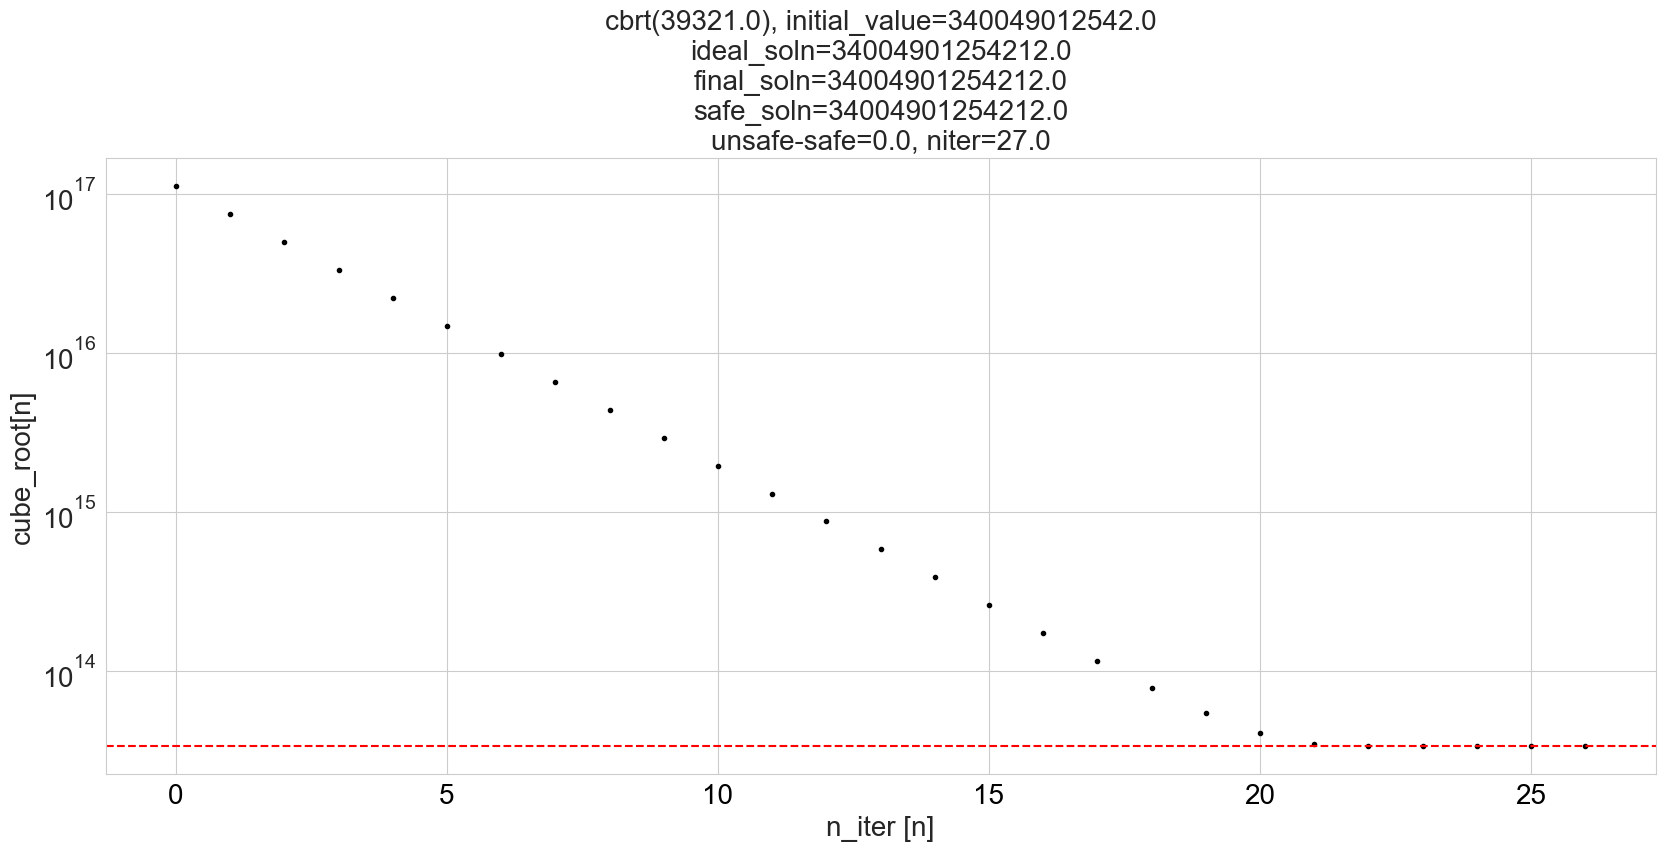

In [52]:
converged_soln_most_iterations = subset_data.mask(subset_data == -1).drop(
    ['input', 'initial_value', 'cbrt_ideal', 'cbrt_safe_implementation', 'cbrt_implementation'], 
    axis=1
).dropna().niter.idxmax()
plot_iterations(converged_soln_most_iterations)

Check if there are converged solutions that differ between safe and unsafe implementations:

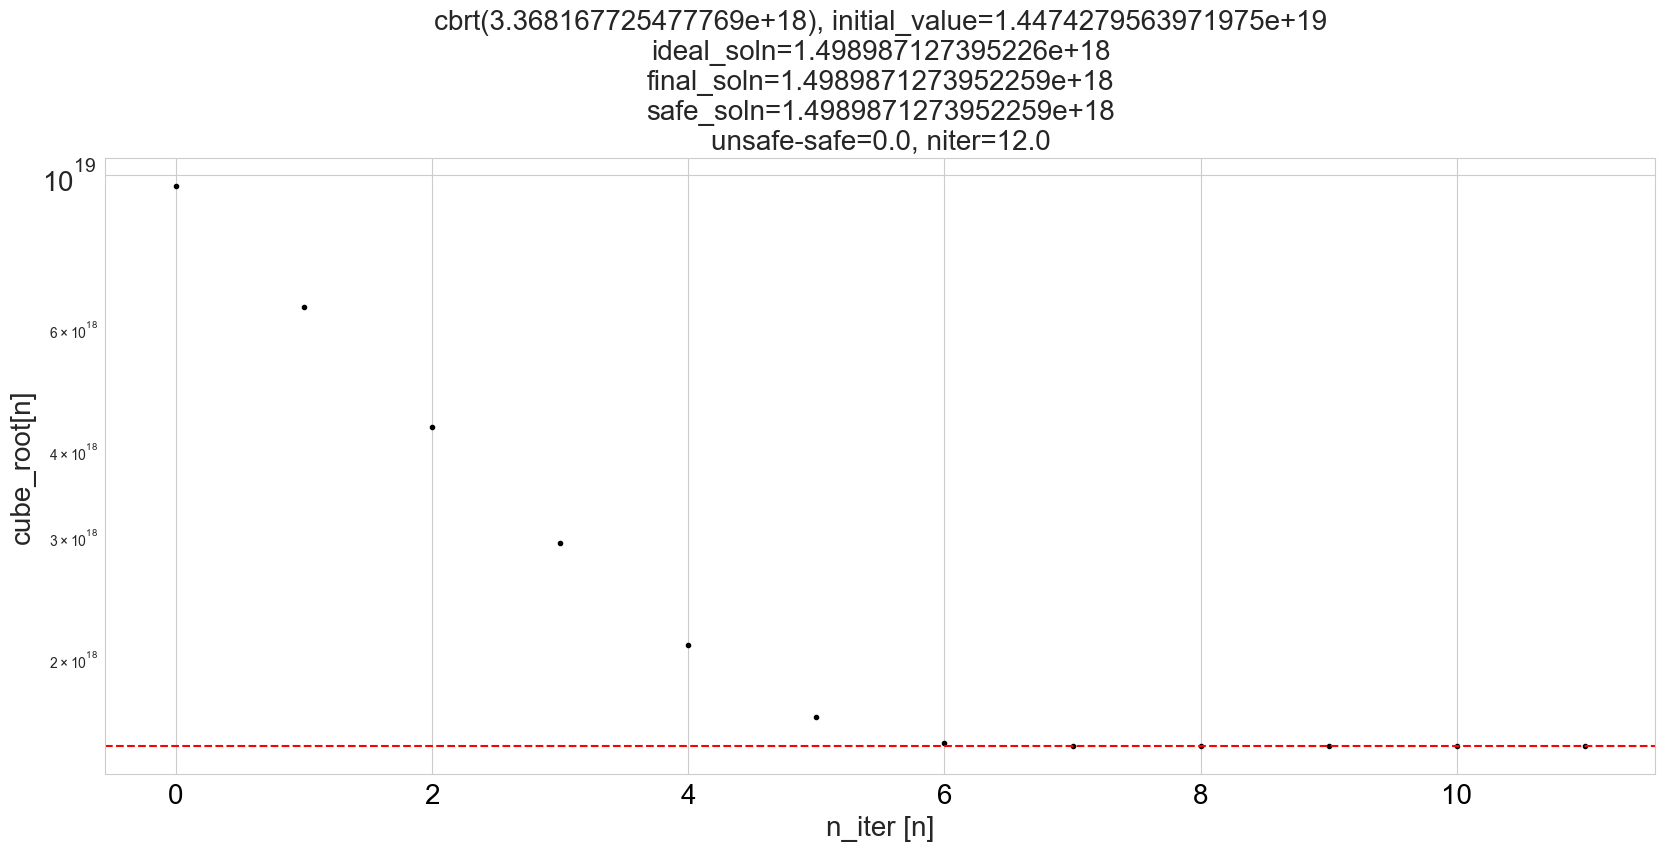

In [53]:
plot_iterations((subset_data['cbrt_implementation'] - subset_data['cbrt_safe_implementation']).idxmax())